# Постановка задачи кластеризации

Пусть $X$ — множество объектов, $Y$ — множество номеров (имён, меток) кластеров. 
- Задана функция расстояния между объектами $ \rho(x,x')$. 
- Имеется конечная обучающая выборка объектов $X^m = \{ x_1, \dots, x_m \} \subset X$. 
- Требуется разбить выборку на непересекающиеся подмножества, называемые кластерами, так, чтобы каждый кластер состоял из объектов, близких по метрике $\rho$, а объекты разных кластеров существенно отличались. При этом каждому объекту $x_i\in X^m$ приписывается номер кластера $y_i$.

Алгоритм кластеризации — это функция $a:\, X\to Y$, которая любому объекту $x\in X$ ставит в соответствие номер кластера $y\in Y$. Множество $Y$ в некоторых случаях известно заранее, однако чаще ставится задача определить оптимальное число кластеров, с точки зрения того или иного критерия качества кластеризации.


Кластеризация (обучение без учителя) отличается от классификации (обучения с учителем) тем, что метки исходных объектов $y_i$ изначально не заданы, и даже может быть неизвестно само множество $Y$.

Выше постановка чёткой кластеризации (одному объекту сопоставляется один кластер). Выделяют ещё нечеткую кластеризацию, когда одному объекту сопоставляется несколько кластеров, с некоторыми весами. С ней вы встретитесь при работе над тематическим моделированием.

## Ничего идеального нет

Введем несколько определений.

*Определение 1:*
> Алгоритм кластеризации $a$ является **масштабно-инвариантным** (англ. scale-invariant), если для любой функции расстояния $\rho$ и любой константы $\alpha>0$ результаты кластеризации с использованием расстояний $ρ$ и $α⋅ρ$ совпадают.

*Определение 2:*
> **Полнота** (англ. Richness). Множество результатов кластеризации алгоритма $a$ в зависимости от изменения функции расстояния $ρ$ должно совпадать со множеством всех возможных разбиений множества объектов $X$.

*Определение 3:*
> Функция расстояния $ρ′$ является **допустимым преобразованием** функции расстояния $ρ$, если
  1. $\rho′(x_i,x_j)\leq\rho(x_i,x_j)$, если $x_i$ и $x_j$ лежат в одном кластере; (сужает)
  2. $\rho′(x_i,x_j)\geq \rho(x_i,x_j)$, если $x_i$ и $x_j$ лежат в разных кластерах. (растягивает)

*Определение 4:*
> Алгоритм кластеризации является **согласованным** (англ. consistent), если результат кластеризации не изменяется после допустимого преобразования функции расстояния.

---
**Теорема Клейнберга о невозможности:**
> Для множества объектов, состоящего из двух и более элементов, не существует алгоритма кластеризации, который был бы одновременно *масштабно-инвариантным*, *согласованным* и *полным*.



Доказательство: https://www.cs.cornell.edu/home/kleinber/nips15.pdf

Решение задачи кластеризации принципиально неоднозначно, и тому есть несколько причин:

- Не существует однозначно **наилучшего критерия качества** кластеризации. Известен целый ряд эвристических критериев, а также ряд алгоритмов, не имеющих чётко выраженного критерия, но осуществляющих достаточно разумную кластеризацию «по построению». Все они могут давать разные результаты.
- **Число кластеров**, как правило, неизвестно заранее и устанавливается в соответствии с некоторым субъективным критерием.
- Результат кластеризации существенно зависит от **метрики**, выбор которой, как правило, также субъективен и определяется экспертом.

# Генерация датасета

Два варианта:
- sklearn.datasets.make_blobs -- сгенерировать просто точки (сужает количество вариантов используемых метрик качества, но близко к реальной постановке).<details>
<summary>на самом деле нет</summary>
make_blobs тоже генерирует информацию о принадлежности к кластеру, поищите (thx to GUN1A)
</details>
- sklearn.datasets.make_classification -- сгенерировать точки и метки для них (метки при обучении не используются, только при оценке качества).



In [47]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import davies_bouldin_score

In [2]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


data, data_y = make_classification(n_samples=300, n_classes=2, n_features=2, n_redundant=0, n_clusters_per_class=1, flip_y=0, random_state=110)

In [14]:
data1, data_y1 =  make_classification(n_samples=300, n_classes=3, n_features=2, n_redundant=0, n_clusters_per_class=1, flip_y=0,n_informative =2, random_state=110)

In [15]:
data2, data_y2 =  make_classification(n_samples=300, n_classes=4, n_features=2, n_redundant=0, n_clusters_per_class=1, flip_y=0,n_informative =2, random_state=110)

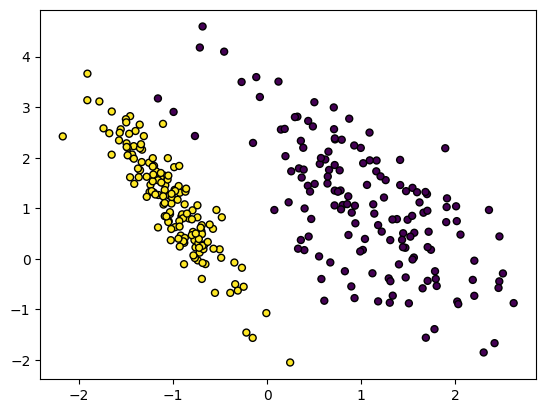

In [5]:
plt.scatter(data[:, 0], data[:, 1], marker="o", c=data_y, s=25, edgecolor="k")
plt.show()

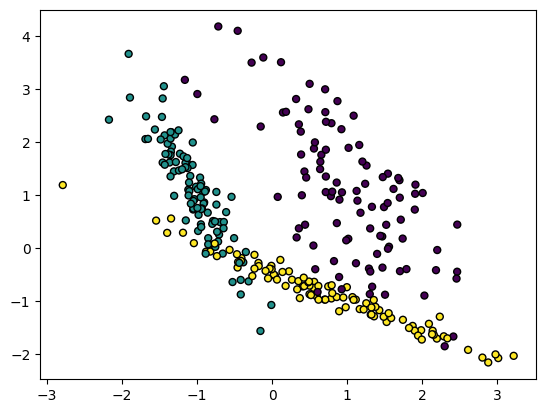

In [6]:
plt.scatter(data1[:, 0], data1[:, 1], marker="o", c=data_y1, s=25, edgecolor="k")
plt.show()

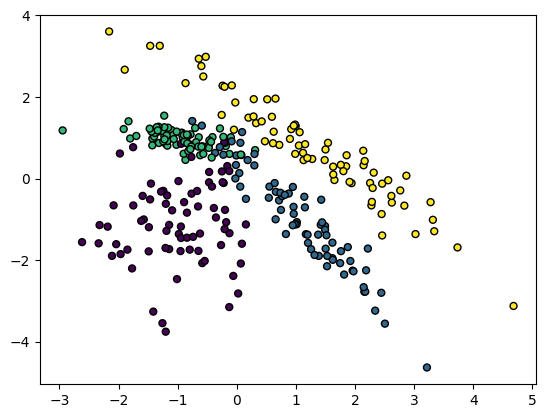

In [7]:
plt.scatter(data2[:, 0], data2[:, 1], marker="o", c=data_y2, s=25, edgecolor="k")
plt.show()

# Алгоритмы кластеризации

## K-means

[Описание метода](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85)

![](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

Шаги алгоритма:
```
1. Выбрать случайно координаты центроидов для каждого кластера.
2. Посчитать расстояния от каждого объекта до центроидов.
3. Посчитать центр масс (центроид) каждого кластера.
4. Проверить условие остановки, вернуться к шагу 2.
```

От начального выбора центроидов зависит качество и скорость сходимости. Существуют модификации, которые улучшают случайный выбор ([K-means++](https://ru.wikipedia.org/wiki/K-means%2B%2B), например)

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(2, n_init='auto').fit(data)

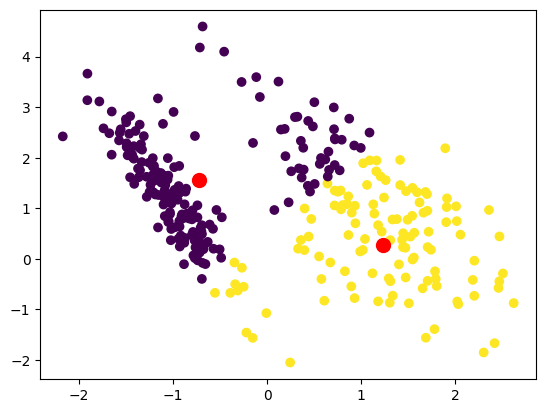

In [9]:
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

In [10]:
print("Внешние",rand_score(kmeans.labels_,data_y),homogeneity_score(kmeans.labels_,data_y))
print("Внутренние" ,davies_bouldin_score(data,kmeans.labels_),silhouette_score(data,kmeans.labels_) )

Внешние 0.6870457079152731 0.3344626663245224
Внутренние 0.9106720014294277 0.43252983706887127


In [11]:
kmeans = KMeans(3, n_init='auto').fit(data1)

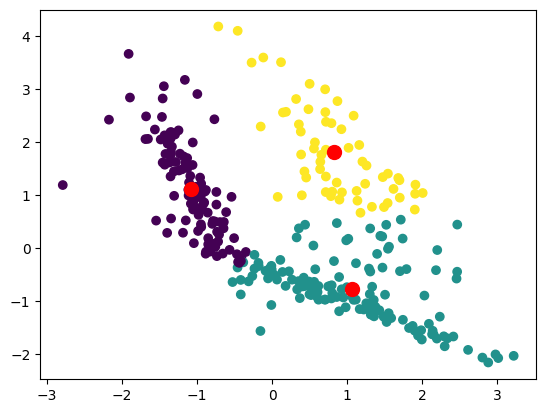

In [12]:
plt.scatter(data1[:,0], data1[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

In [13]:
print("Внешние",rand_score(kmeans.labels_,data_y1),homogeneity_score(kmeans.labels_,data_y1))
print("Внутренние" ,davies_bouldin_score(data1,kmeans.labels_),silhouette_score(data1,kmeans.labels_) )

Внешние 0.7710367892976588 0.5363730903249753
Внутренние 0.8099222209544049 0.46884781699424716


In [14]:
kmeans = KMeans(4, n_init='auto').fit(data2)

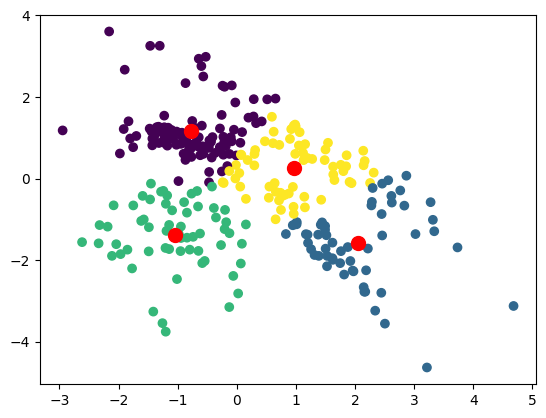

In [15]:
plt.scatter(data2[:,0], data2[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

In [16]:
print("Внешние",rand_score(kmeans.labels_,data_y2),homogeneity_score(kmeans.labels_,data_y2))
print("Внутренние" ,davies_bouldin_score(data2,kmeans.labels_),silhouette_score(data2,kmeans.labels_) )

Внешние 0.7742028985507247 0.4896846166762369
Внутренние 0.821712973352176 0.4183405752043203


# Подбор оптимального количества кластеров

Количество кластеров -- обычный гиперпараметр.
Т.о. для подбора оптимального гиперпараметра нужно определиться с оценкой качества алгоритма и списком значений для гиперпараметра. 

4


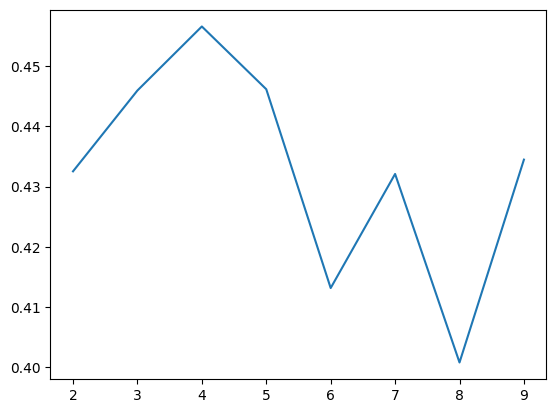

In [17]:
from sklearn.metrics import silhouette_score
import numpy as np
ss = []

for i in range(2, 10):
  ss.append(silhouette_score(data, KMeans(i, n_init='auto').fit(data).labels_))

plt.plot(range(2,10), ss)
print(np.argmax(ss)+2)

3


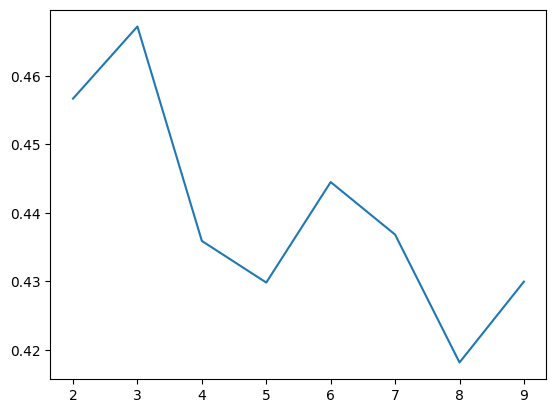

In [18]:
ss = []

for i in range(2, 10):
  ss.append(silhouette_score(data1, KMeans(i, n_init='auto').fit(data1).labels_))

plt.plot(range(2,10), ss)
print(np.argmax(ss)+2)

3


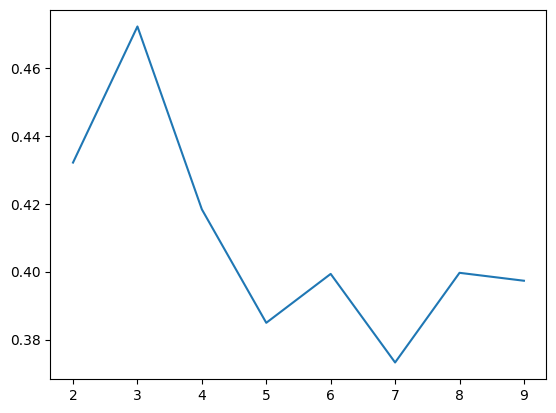

In [19]:
ss = []

for i in range(2, 10):
  ss.append(silhouette_score(data2, KMeans(i, n_init='auto').fit(data2).labels_))

plt.plot(range(2,10), ss)
print(np.argmax(ss)+2)

# Алгоритмы кластеризации

## Affinity propagation

[Хорошее объяснение](https://habr.com/ru/articles/321216/)

Affinity Propagation (AP) - это алгоритм кластеризации, основанный на передаче сообщений между точками данных. В отличие от других алгоритмов кластеризации, таких как K-means, AP не требует заранее определенного числа кластеров. Для этой цели двумя важными параметрами являются "preference", которые контролируют количество экземпляров и "damping factor", который снижает ответственность и доступность сообщений, чтобы избежать числовых колебаний при обновлении этих сообщений. Подбираются через поиск по сетке.

---

Шаги работы алгоритма Affinity Propagation:
1. Инициализация: Создайте матрицу сходства S, где каждый элемент s(i, j) представляет сходство между точками данных i и j. Обычно сходство определяется как отрицательное квадратное евклидово расстояние. Затем инициализируйте две другие матрицы: матрицу ответственности R и матрицу доступности A, заполнив их нулями.

2. Обновление ответственности: Обновите матрицу ответственности R, используя текущие значения матрицы доступности A и матрицы сходства S. Ответственность r(i, k) отражает насколько подходящим является объект k в качестве экземпляра для объекта i.

3. Обновление доступности: Обновите матрицу доступности A, используя текущие значения матрицы ответственности R. Доступность a(i, k) отражает насколько подходящим является объект i для выбора объекта k в качестве экземпляра.

4. Сходимость: Повторяйте шаги 2 и 3 до тех пор, пока не будет достигнут критерий сходимости. Обычно это означает, что значения матриц R и A стабилизируются после определенного числа итераций.


Выделение кластеров: После сходимости определите кластеры, выбрав для каждого объекта i экземпляр k, который максимизирует сумму ответственности r(i, k) и доступности a(i, k).
В результате работы алгоритма Affinity Propagation получаем кластеры с автоматически определенным числом кластеров и экземплярами, представляющими каждый кластер.


c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\mal

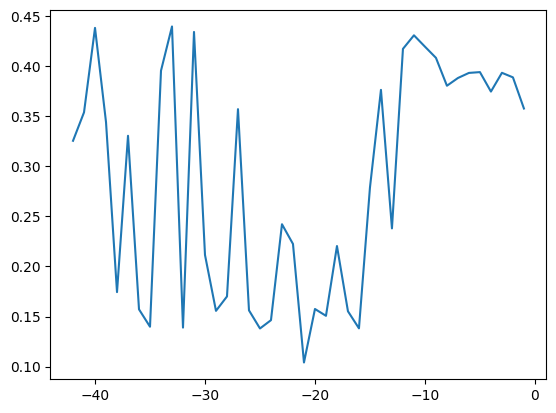

In [100]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference=-42).fit(data)
ss = []
for preference in range(-42,0):
    clustering.set_params(preference=preference)
    ss.append(silhouette_score(data, clustering.fit(data).labels_))

plt.plot(range(-42,0), ss)

c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


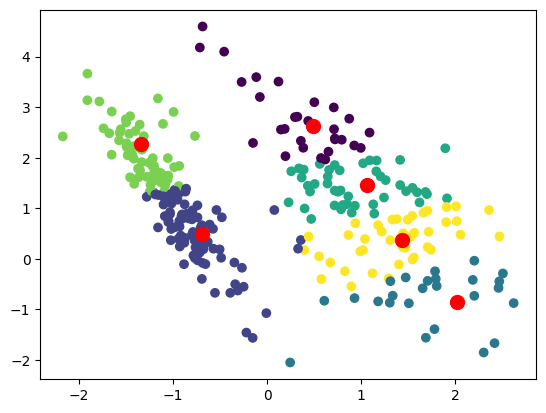

In [102]:
clustering.set_params(preference=-18)
clustering.fit(data)
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)
plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=100, c='red')

In [48]:
print("Внешние",rand_score(clustering.labels_,data_y),homogeneity_score(clustering.labels_,data_y))
print("Внутренние" ,davies_bouldin_score(data,clustering.labels_),silhouette_score(data,clustering.labels_) )

Внешние 0.5001560758082497 0.0026503615830918603
Внутренние 51.714300371940894 -0.06167104847902213


c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\mal

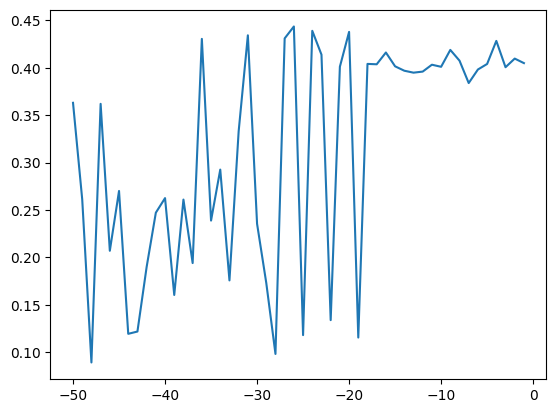

In [106]:
clustering = AffinityPropagation(preference=-42).fit(data1)
ss = []
for preference in range(-50,0):
    clustering.set_params(preference=preference)
    ss.append(silhouette_score(data1, clustering.fit(data1).labels_))

plt.plot(range(-50,0), ss)

c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


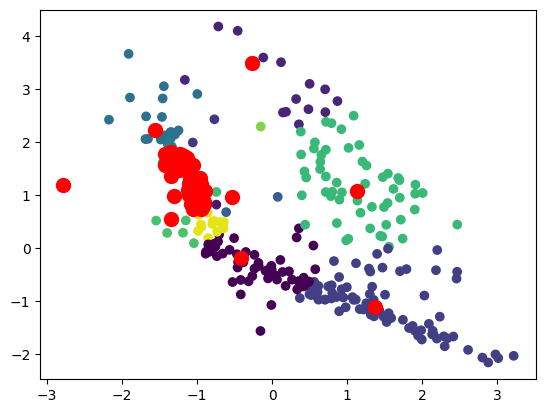

In [107]:

clustering = AffinityPropagation(preference=-48).fit(data1)

plt.scatter(data1[:,0], data1[:,1], c=clustering.labels_)
plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=100, c='red')

In [108]:
print("Внешние",rand_score(clustering.labels_,data_y1),homogeneity_score(clustering.labels_,data_y1))
print("Внутренние" ,davies_bouldin_score(data1,clustering.labels_),silhouette_score(data1,clustering.labels_) )

Внешние 0.7218952062430324 0.2968826539611927
Внутренние 0.7794745879174588 0.20362476656425507


c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\malya\Desktop\projects\маш обуч\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\Users\mal

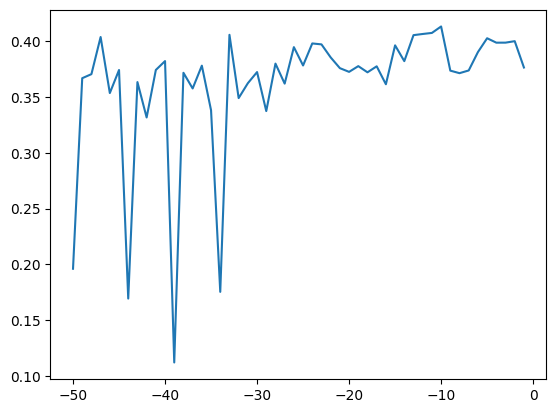

In [109]:
clustering = AffinityPropagation(preference=-42).fit(data2)
ss = []
for preference in range(-50,0):
    clustering.set_params(preference=preference)
    ss.append(silhouette_score(data2, clustering.fit(data2).labels_))

plt.plot(range(-50,0), ss)

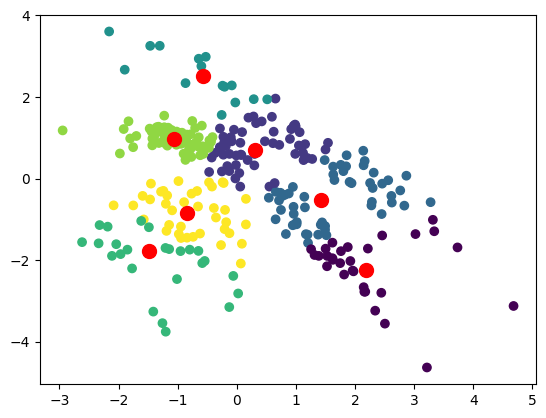

In [110]:

clustering = AffinityPropagation(preference=-38).fit(data2)

plt.scatter(data2[:,0], data2[:,1], c=clustering.labels_)
plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=100, c='red')

In [54]:
print("Внешние",rand_score(clustering.labels_,data_y2),homogeneity_score(clustering.labels_,data_y2))
print("Внутренние" ,davies_bouldin_score(data2,clustering.labels_),silhouette_score(data2,clustering.labels_) )

Внешние 0.7793979933110368 0.4103277910168799
Внутренние 1.0794850525596602 0.33160227310328466


## DB-SCAN


- Находим точки в $\epsilon$  окрестности каждой точки и выделяем основные точки с более чем minPts соседями.

- Находим связные компоненты основных точек на графе соседей, игнорируя все неосновные точки.

- Назначаем каждую неосновную ближайшему кластеру, если кластер является $\epsilon$ -соседним, в противном случае считаем точку шумом.

In [12]:
from sklearn.cluster import DBSCAN
import numpy as np


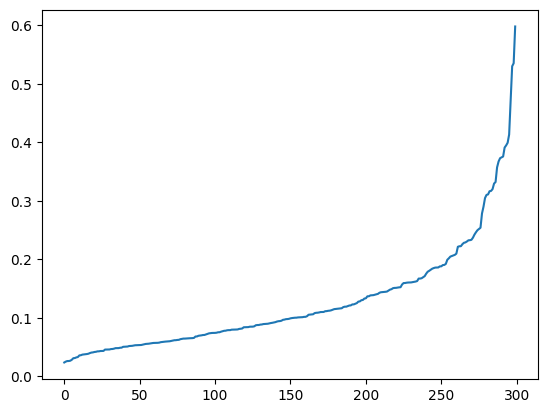

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=4).fit(data)
distances, indices = nbrs.kneighbors(data)
distances = np.mean(distances, axis=1)
distances = np.sort(distances)
plt.plot(distances)

[-1  0  1  2  3  4  5  6  7]


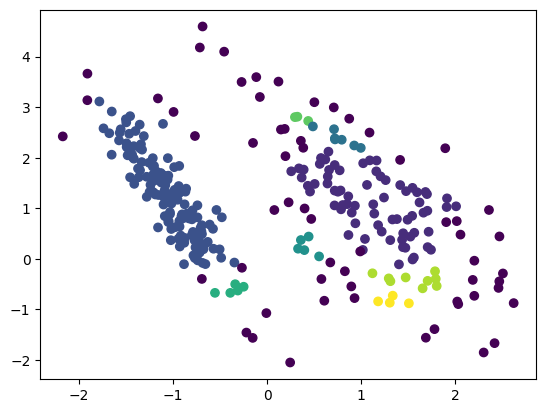

In [59]:
dbscan = DBSCAN(eps=0.25, min_samples=4).fit(data)
print(np.unique(dbscan.labels_))
plt.scatter(data[:,0], data[:,1], c=dbscan.labels_)

In [60]:
print("Внешние",rand_score(dbscan.labels_,data_y),homogeneity_score(dbscan.labels_,data_y))
print("Внутренние" ,davies_bouldin_score(data,dbscan.labels_),silhouette_score(data,dbscan.labels_) )

Внешние 0.7826755852842809 0.4184091769774662
Внутренние 2.5428419807185976 0.06028879412822108


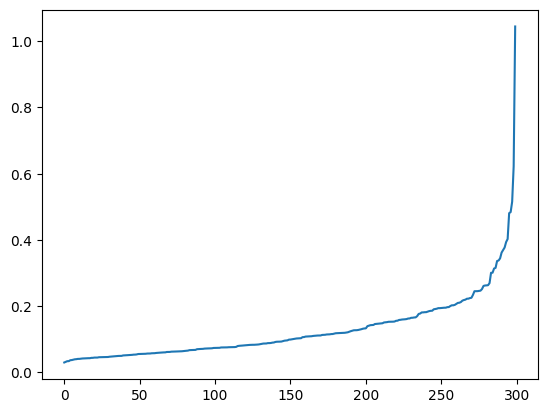

In [61]:
nbrs = NearestNeighbors(n_neighbors=4).fit(data1)
distances, indices = nbrs.kneighbors(data1)
distances = np.mean(distances, axis=1)
distances = np.sort(distances)
plt.plot(distances)

[-1  0  1  2  3  4  5]


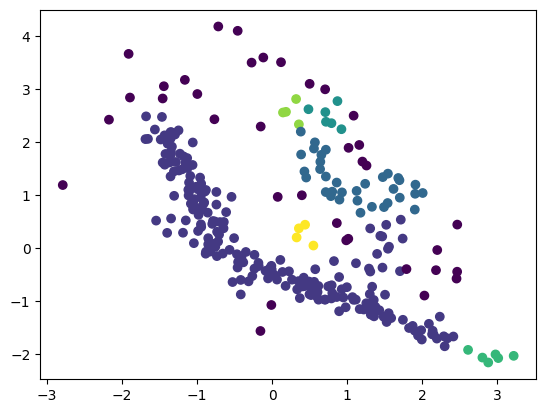

In [62]:
dbscan = DBSCAN(eps=0.3, min_samples=4).fit(data1)
print(np.unique(dbscan.labels_))
plt.scatter(data1[:,0], data1[:,1], c=dbscan.labels_)

In [63]:
print("Внешние",rand_score(dbscan.labels_,data_y1),homogeneity_score(dbscan.labels_,data_y1))
print("Внутренние" ,davies_bouldin_score(data1,dbscan.labels_),silhouette_score(data1,dbscan.labels_) )

Внешние 0.5906354515050167 0.3388592659537055
Внутренние 2.475567106808403 -0.1981887964688491


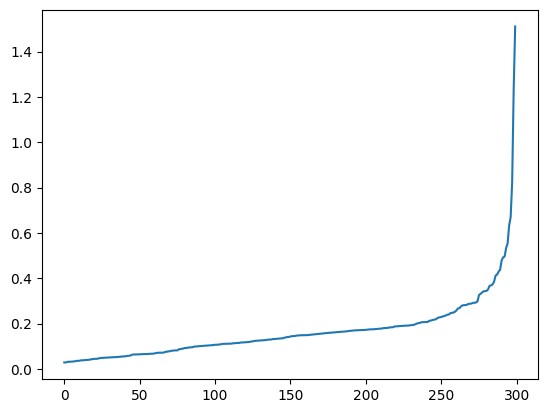

In [20]:
nbrs = NearestNeighbors(n_neighbors=4).fit(data2)
distances, indices = nbrs.kneighbors(data2)
distances = np.mean(distances, axis=1)
distances = np.sort(distances)
plt.plot(distances)

[-1  0  1  2  3  4]


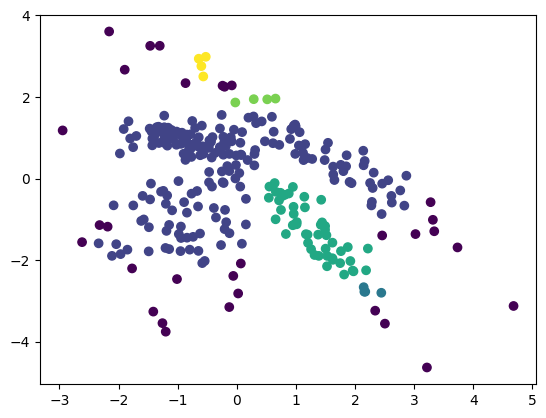

In [65]:
dbscan = DBSCAN(eps=0.38, min_samples=4).fit(data2)
print(np.unique(dbscan.labels_))
plt.scatter(data2[:,0], data2[:,1], c=dbscan.labels_)

In [66]:
print("Внешние",rand_score(dbscan.labels_,data_y2),homogeneity_score(dbscan.labels_,data_y2))
print("Внутренние" ,davies_bouldin_score(data2,dbscan.labels_),silhouette_score(data2,dbscan.labels_) )

Внешние 0.5708138238573022 0.3966363830873415
Внутренние 2.2987979925600404 -0.005367870749413527


# Gaussian Mixtures, EM

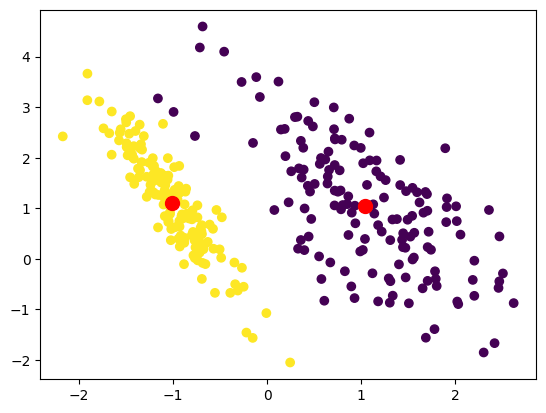

In [70]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(data)

gm.predict(data)

plt.scatter(data[:,0], data[:,1], c=gm.predict(data))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

In [71]:
print("Внешние",rand_score(gm.predict(data),data_y),homogeneity_score(gm.predict(data),data_y))
print("Внутренние" ,davies_bouldin_score(data,gm.predict(data)),silhouette_score(data,gm.predict(data)) )

Внешние 1.0 1.0
Внутренние 1.0300035375018937 0.42039344760255126


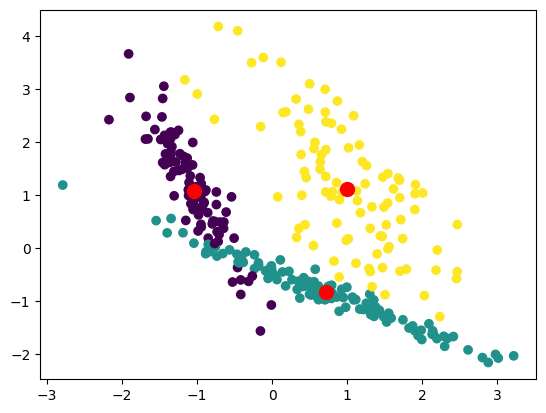

In [72]:
gm = GaussianMixture(n_components=3).fit(data1)

gm.predict(data1)

plt.scatter(data1[:,0], data1[:,1], c=gm.predict(data1))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

In [73]:
print("Внешние",rand_score(gm.predict(data1),data_y1),homogeneity_score(gm.predict(data1),data_y1))
print("Внутренние" ,davies_bouldin_score(data1,gm.predict(data1)),silhouette_score(data1,gm.predict(data1)) )

Внешние 0.9272017837235228 0.7960241487450385
Внутренние 1.0794327753459687 0.3217677734296919


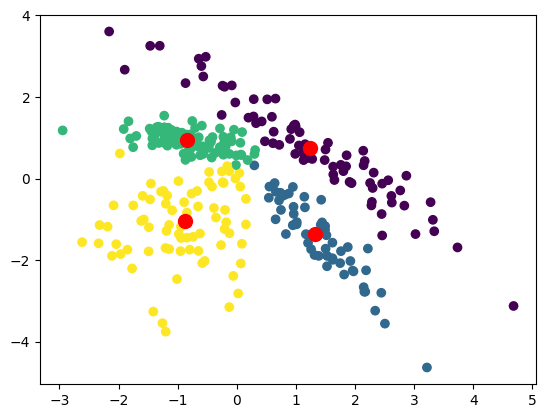

In [74]:
gm = GaussianMixture(n_components=4).fit(data2)

gm.predict(data2)

plt.scatter(data2[:,0], data2[:,1], c=gm.predict(data2))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

In [75]:
print("Внешние",rand_score(gm.predict(data2),data_y2),homogeneity_score(gm.predict(data2),data_y2))
print("Внутренние" ,davies_bouldin_score(data2,gm.predict(data2)),silhouette_score(data2,gm.predict(data2)) )

Внешние 0.9247491638795987 0.8186491268131826
Внутренние 1.011240106905145 0.34043407321775393


## Иерархическая кластеризация

https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering


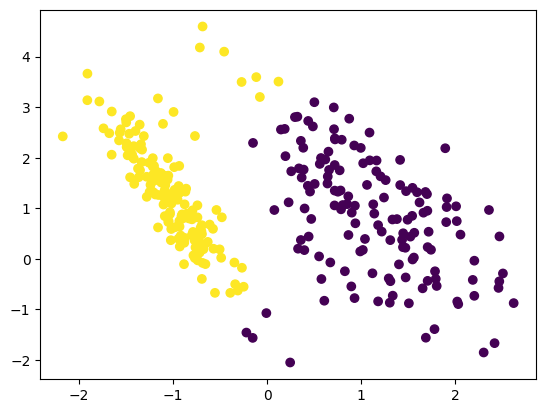

In [78]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=2, linkage="ward").fit(data)
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

In [79]:
print("Внешние",rand_score(clustering.labels_,data_y),homogeneity_score(clustering.labels_,data_y))
print("Внутренние" ,davies_bouldin_score(data,clustering.labels_),silhouette_score(data,clustering.labels_) )

Внешние 0.9107246376811594 0.7343188866141305
Внутренние 0.9508264918207149 0.43950888891919393


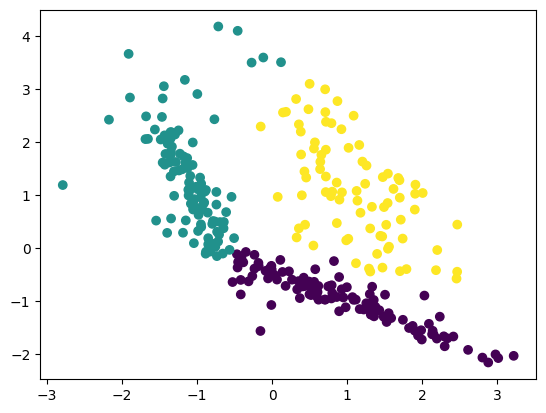

In [36]:

clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(data1)
plt.scatter(data1[:,0], data1[:,1], c=clustering.labels_)

In [80]:
print("Внешние",rand_score(clustering.labels_,data_y1),homogeneity_score(clustering.labels_,data_y1))
print("Внутренние" ,davies_bouldin_score(data1,clustering.labels_),silhouette_score(data1,clustering.labels_) )

Внешние 0.50082497212932 0.00598742674156175
Внутренние 9.304035143464558 0.009519546334211275


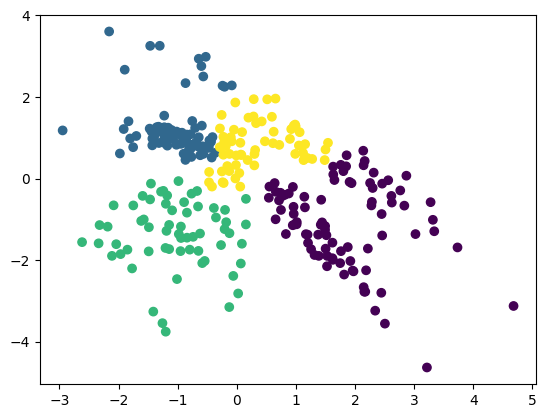

In [81]:
clustering = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(data2)
plt.scatter(data2[:,0], data2[:,1], c=clustering.labels_)

In [82]:
print("Внешние",rand_score(clustering.labels_,data_y2),homogeneity_score(clustering.labels_,data_y2))
print("Внутренние" ,davies_bouldin_score(data2,clustering.labels_),silhouette_score(data2,clustering.labels_) )

Внешние 0.7987513935340023 0.5052082605495015
Внутренние 0.8623949489295963 0.37850194665431597


## Карты Кохонена


Крутой разбор: https://habr.com/ru/articles/338868/



In [9]:
%pip install sklearn_som 


  Using cached sklearn_som-1.1.0-py3-none-any.whl (6.7 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\malya\Desktop\projects\маш обуч\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [83]:
from sklearn_som.som import SOM

In [84]:
iris_som = SOM(m=2, n=1, dim=2)
iris_som.fit(data)

In [85]:
predictions = iris_som.predict(data)

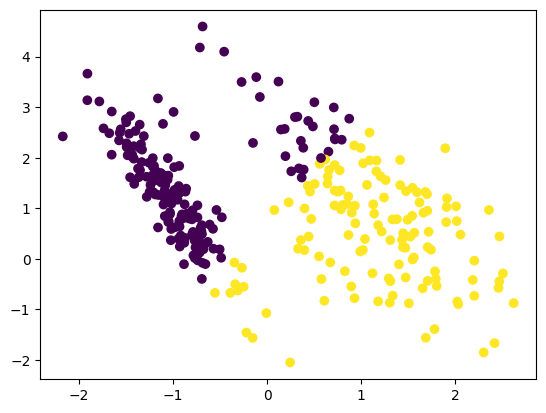

In [86]:
plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
plt.show()

In [87]:
print("Внешние",rand_score(predictions,data_y),homogeneity_score(predictions,data_y))
print("Внутренние" ,davies_bouldin_score(data,predictions),silhouette_score(data,predictions) )

Внешние 0.7488517279821628 0.421790917176565
Внутренние 0.927084978781702 0.4319098778907907


In [88]:
iris_som = SOM(m=3, n=1, dim=2)
iris_som.fit(data1)

In [89]:
predictions = iris_som.predict(data1)

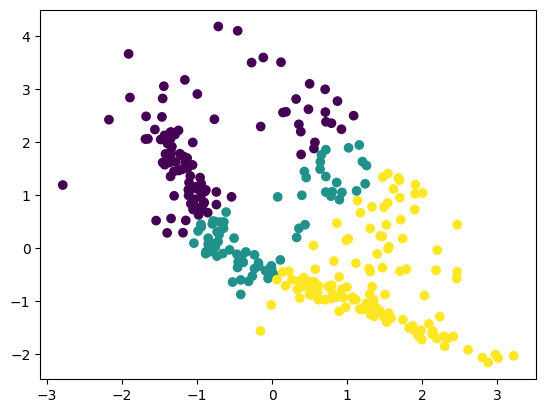

In [90]:
plt.scatter(data1[:, 0], data1[:, 1], c=predictions, cmap='viridis')
plt.show()

In [91]:
print("Внешние",rand_score(predictions,data_y1),homogeneity_score(predictions,data_y1))
print("Внутренние" ,davies_bouldin_score(data1,predictions),silhouette_score(data1,predictions) )

Внешние 0.6563879598662208 0.2431621188975921
Внутренние 1.1414687659098368 0.3164988737339722


In [92]:
iris_som = SOM(m=4, n=1, dim=2)
iris_som.fit(data2)

In [93]:
predictions = iris_som.predict(data2)

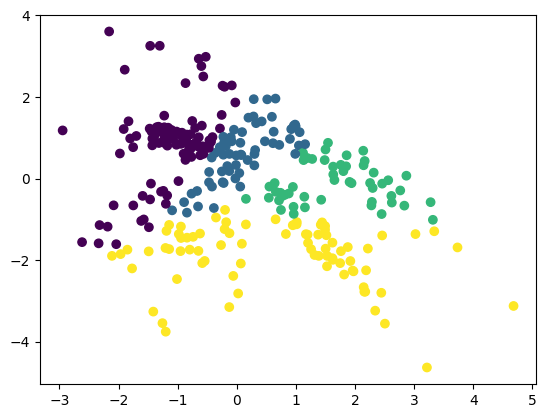

In [94]:
plt.scatter(data2[:, 0], data2[:, 1], c=predictions, cmap='viridis')
plt.show()

In [95]:
print("Внешние",rand_score(predictions,data_y2),homogeneity_score(predictions,data_y2))
print("Внутренние" ,davies_bouldin_score(data2,predictions),silhouette_score(data2,predictions) )

Внешние 0.7146042363433668 0.3108043460363562
Внутренние 1.227413092119561 0.24094898537144327


# Задание

1. Сгенерировать 3 датасета (make_classification или make_blobs)
2. Провести визуализацию
3. Провести кластеризацию (все методы)
4. Для каждого метода подобрать оптимальные гипер-параметры.
5. Самостоятельно реализовать KMeans. Проверить его работу на датасетах.
6. Каждый метод оценивать 2 внешними и 2 внутренними метриками.

# Доп. задание:

Реализовать DB-Scan

$%внизу лишний пробел$
! [](https://wojakparadise.net/wojak/3038/img)

In [1]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

from src.Clustering.KMeans import myKMeans

from src.Clustering.dbscan import dbscan

In [4]:
kmeans = myKMeans(n_clusters=4)
kmeans.fit(data)

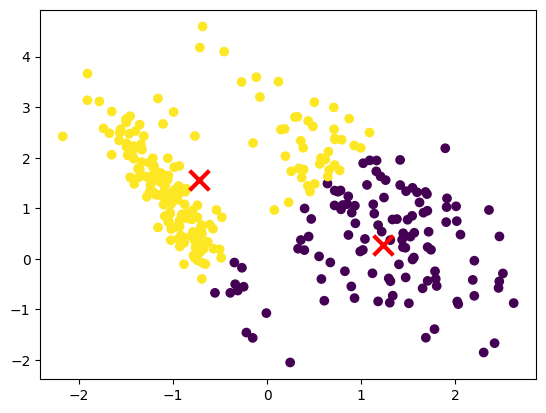

In [8]:
labels = kmeans.predict(data)

# Визуализируем кластеры
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.show()

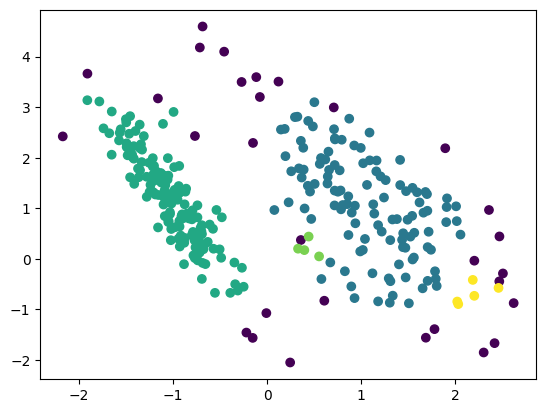

In [10]:
labels = dbscan(data, eps=0.35, min_samples=5)

# Визуализируем кластеры
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.show()